In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install scikit-learn
!pip install streamlit
from sklearn.cluster import KMeans
import seaborn as sns
import streamlit as st
from sklearn.preprocessing import StandardScaler

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
data = pd.read_csv(r'D:\Stuff\New Datasets\LondonBikeJourneyAug2023.csv')

In [4]:
data.head(10)

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,132825189,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663
1,132825190,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128
2,132825191,8/1/2023 0:00,983,"Euston Road, Euston",8/1/2023 0:11,3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395
3,132825192,8/1/2023 0:01,3479,"Old Brompton Road, South Kensington",8/1/2023 0:12,1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059
4,132825193,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",8/1/2023 0:17,200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786
5,132825194,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",8/1/2023 0:08,1205,"Black Prince Road, Vauxhall",52921,CLASSIC,7m 45s,465422
6,132825195,8/1/2023 0:01,200120,"Grant Road East, Clapham Junction",8/1/2023 0:04,200126,"Usk Road, Clapham Junction",59224,CLASSIC,3m 26s,206583
7,132825196,8/1/2023 0:01,200155,"Gascoyne Road, Victoria Park",8/1/2023 1:04,3469,"Cadogan Place, Knightsbridge",61178,PBSC_EBIKE,1h 2m 58s,3778515
8,132825197,8/1/2023 0:01,300202,"Kings Gate House, Westminster",8/1/2023 0:18,1210,"Nevern Place, Earl's Court",51757,CLASSIC,17m 5s,1025908
9,132825198,8/1/2023 0:01,1154,"Kennington Road , Vauxhall",8/1/2023 0:09,1093,"Kennington Cross, Kennington",53424,CLASSIC,7m 16s,436692


## Finding missing values

In [5]:
data.isnull().sum()

Number                  0
Start date              0
Start station number    0
Start station           0
End date                0
End station number      0
End station             0
Bike number             0
Bike model              0
Total duration          0
Total duration (ms)     0
dtype: int64

In [12]:
data.describe()

,Number,Start station number,End station number,Bike number,Total duration (ms)
count,7.765270e+05,7.765270e+05,7.765270e+05,776527.000000,7.765270e+05
mean,1.332250e+08,1.048377e+05,1.044439e+05,49568.888425,1.554986e+06
std,2.307174e+05,1.277670e+05,1.278823e+05,13092.003305,1.729002e+07
min,1.328252e+08,9.590000e+02,9.590000e+02,2.000000,1.307000e+03
25%,1.330252e+08,1.126000e+03,1.123000e+03,50563.000000,4.854690e+05
50%,1.332248e+08,3.467000e+03,3.465000e+03,54625.000000,8.387700e+05
75%,1.334248e+08,2.001800e+05,2.001810e+05,58168.000000,1.392228e+06
max,1.336251e+08,1.100444e+06,1.100444e+06,61201.000000,7.441908e+09


## Basic Visualization

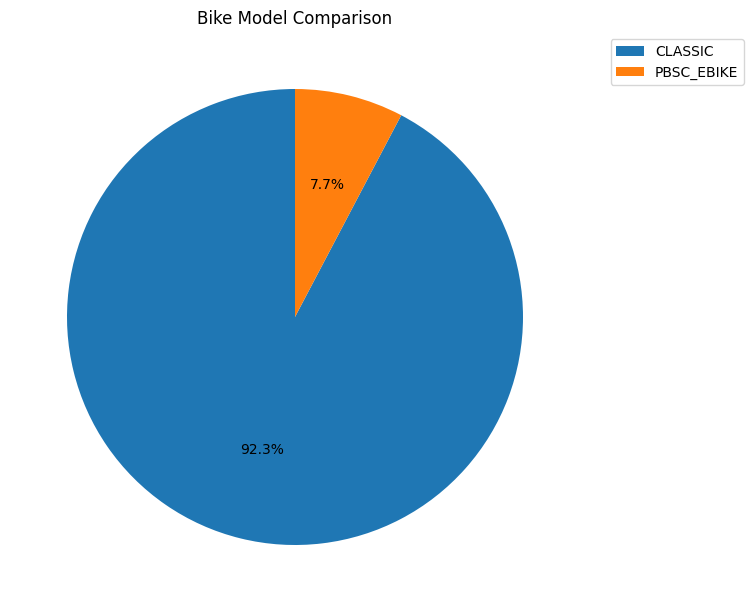

In [36]:
# Group by bike model and count distinct rows
bike_counts = data['Bike model'].value_counts().reset_index()

# Rename columns
bike_counts.columns = ['Bike model', 'Count']

# Create a pie chart
plt.figure(figsize=(8,6))
plt.pie(bike_counts['Count'], labels=None, autopct='%1.1f%%', startangle=90)

# Create a legend
plt.legend(bike_counts['Bike model'], loc='upper right', bbox_to_anchor=(1.3, 1))

# Tighten the layout
plt.tight_layout()

plt.title('Bike Model Comparison')
plt.show()

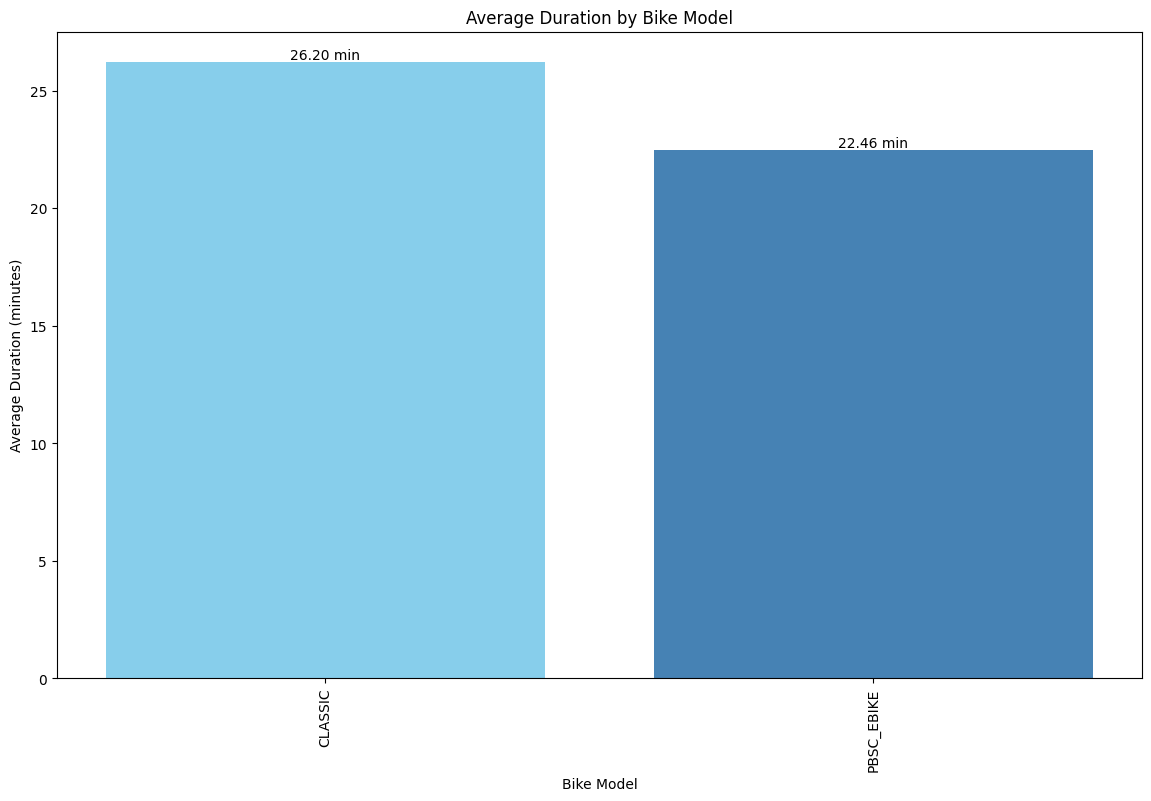

In [25]:
# Group by bike model and calculate average duration
bike_duration = data.groupby('Bike model')['Total duration (ms)'].mean().reset_index()

# Convert average duration from milliseconds to minutes
bike_duration['Average duration (minutes)'] = bike_duration['Total duration (ms)'] / (60 * 1000)

# Create a bar chart
plt.figure(figsize=(14,8.4))  # Increased size by 40%
bars = plt.bar(bike_duration['Bike model'], bike_duration['Average duration (minutes)'], color=['#87CEEB', '#4682B4'] * (len(bike_duration) // 2 + 1))

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f} min', ha='center', va='bottom')

plt.xlabel('Bike Model')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration by Bike Model')
plt.xticks(rotation=90)
plt.show()

### Most Popular Routes

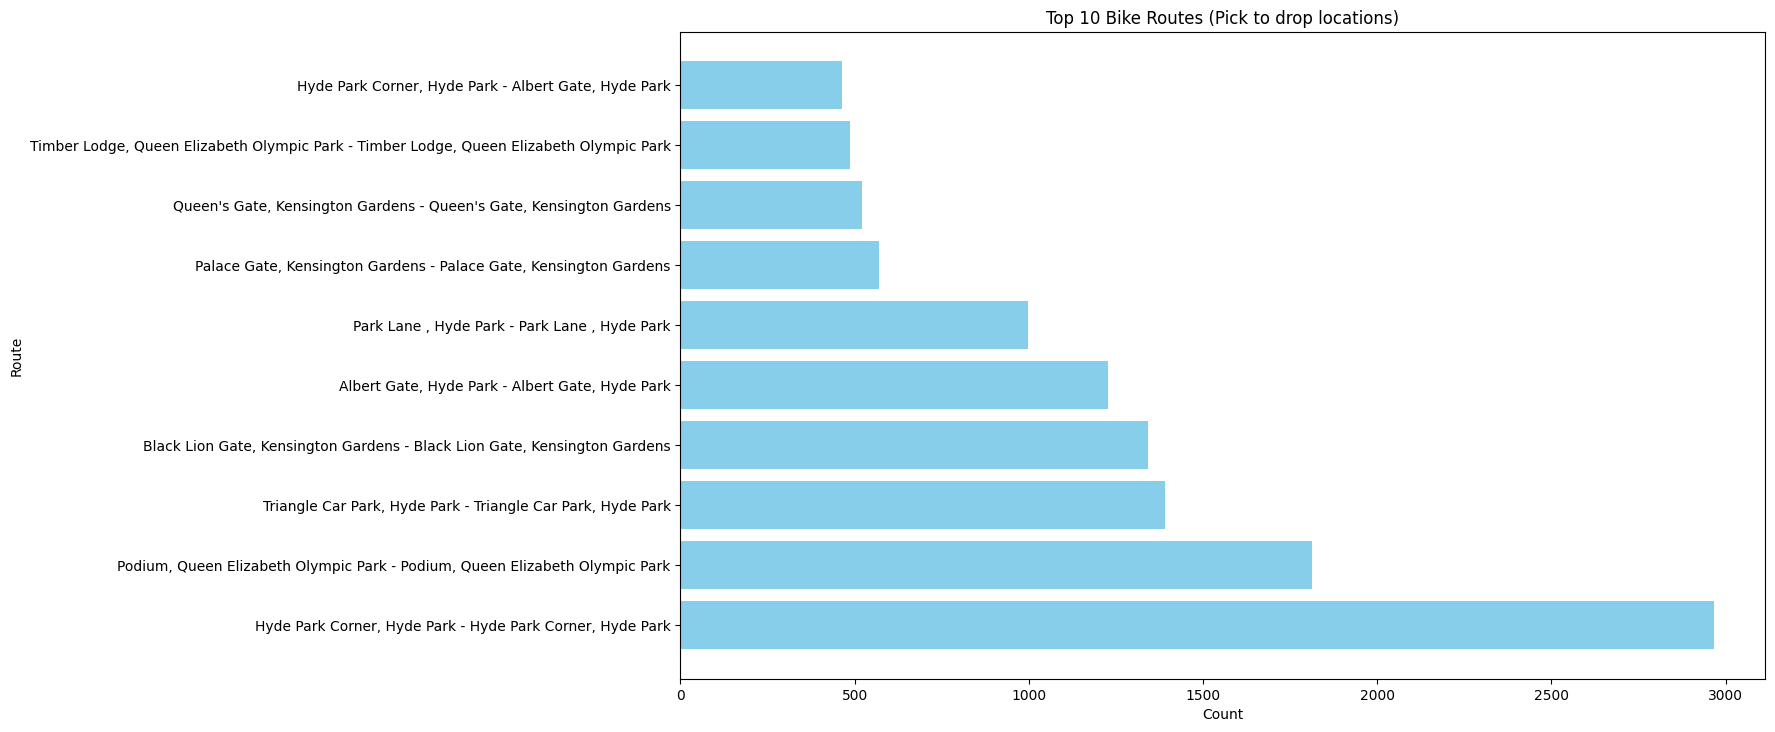

In [32]:
# Group by start and end stations and count distinct combinations
route_counts = data.groupby(['Start station', 'End station']).size().reset_index(name='Count')

# Create a new column with combined station names
route_counts['Route'] = route_counts['Start station'] + ' - ' + route_counts['End station']

# Sort by count in descending order and select top 10 routes
top_routes = route_counts.sort_values('Count', ascending=False).head(10)

# Create a horizontal bar graph
plt.figure(figsize=(14,8.4))
plt.barh(top_routes['Route'], top_routes['Count'], color='#87CEEB')
plt.xlabel('Count')
plt.ylabel('Route')
plt.title('Top 10 Bike Routes (Pick to drop locations)')
plt.show()

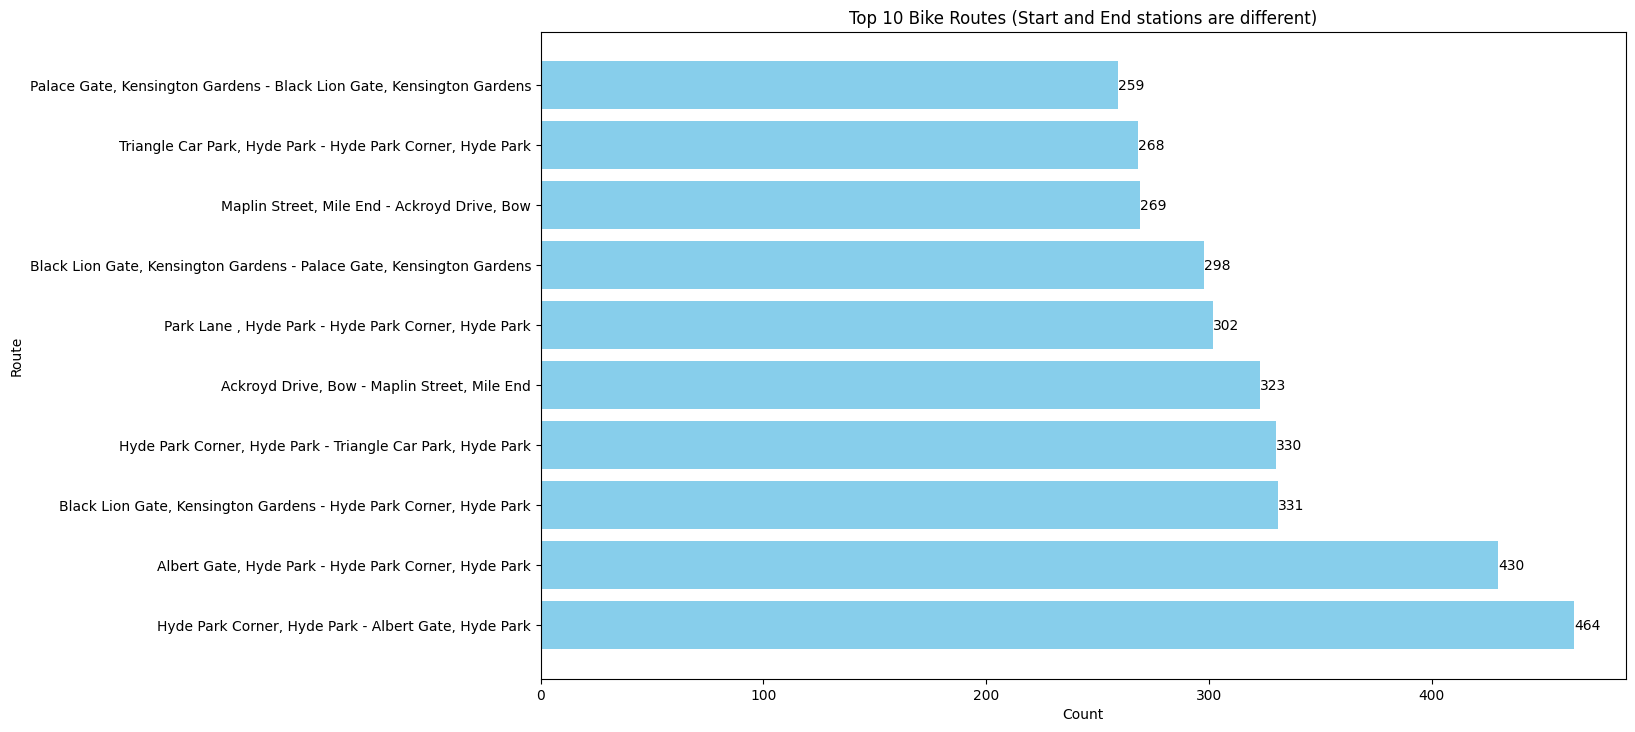

In [30]:
# Filter out rows where start and end stations are the same
data_filtered = data[data['Start station'] != data['End station']]

# Group by start and end stations and count distinct combinations
route_counts = data_filtered.groupby(['Start station', 'End station']).size().reset_index(name='Count')

# Create a new column with combined station names
route_counts['Route'] = route_counts['Start station'] + ' - ' + route_counts['End station']

# Sort by count in descending order and select top 10 routes
top_routes = route_counts.sort_values('Count', ascending=False).head(10)

# Create a horizontal bar graph
plt.figure(figsize=(14,8.4))
bars = plt.barh(top_routes['Route'], top_routes['Count'], color='#87CEEB')

# Add total count on top of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), ha='left', va='center')

plt.xlabel('Count')
plt.ylabel('Route')
plt.title('Top 10 Bike Routes (Start and End stations are different)')
plt.show()

# Machine learning part

### Predicting bike demand through ARIMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create and fit the ARIMA model
model = ARIMA(train_data['Total duration (ms)'], order=(1,1,1))
model_fit = model.fit()

# Generate predictions on the test data
predictions = model_fit.predict(test_data.index)

# Evaluate the model
mae = mean_absolute_error(test_data['Total duration (ms)'], predictions)
mape = mean_absolute_percentage_error(test_data['Total duration (ms)'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['Total duration (ms)'], predictions))

print(f'MAE: {mae:.2f}, MAPE: {mape:.2f}%, RMSE: {rmse:.2f}')

ModuleNotFoundError: No module named 'statsmodels'

### Optimizing bike distribution model


In [9]:
# Select relevant features
features = data[['Total duration (ms)', 'Start station number', 'End station number']]

# Scale features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original data
data['Cluster'] = clusters

C:\Users\Ujjwal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


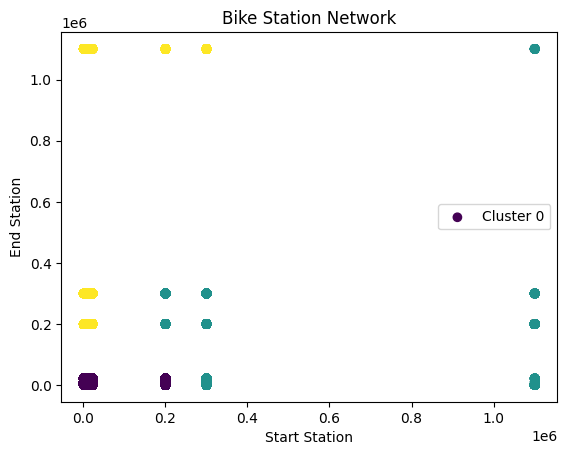

<Figure size 1000x800 with 0 Axes>

In [11]:
# Create a scatter plot of stations with different colors for each cluster
plt.scatter(data['Start station number'], data['End station number'], c=data['Cluster'])

# Add labels and title
plt.xlabel('Start Station')
plt.ylabel('End Station')
plt.title('Bike Station Network')

# Add a legend for clusters
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])

# Use a larger figure size
plt.figure(figsize=(10, 8))

# Show the plot
plt.show()

### Streamlit deployment


In [8]:
# Select relevant features
features = data[['Total duration (ms)', 'Start station number', 'End station number']]

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original data
data['Cluster'] = clusters

# Create a Streamlit app
st.title('Bike Station Network Clustering')

# Show the cluster assignment
st.write(data)

# Create a scatter plot of stations with different colors for each cluster
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(data['Start station number'], data['End station number'], c=data['Cluster'])
ax.set_xlabel('Start Station')
ax.set_ylabel('End Station')
ax.set_title('Bike Station Network')
ax.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])

# Show the plot in Streamlit
st.pyplot(fig)

C:\Users\Ujjwal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\streamlit\elements\pyplot.py:173: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(image, **kwargs)


DeltaGenerator()

SyntaxError: invalid syntax (1135476472.py, line 1)